In [1]:
import gymnasium as gym
import aero_gym
from aero_gym.tools import evaluate, plotfile, animaterender, animaterender_contour
import matplotlib
import math
import numpy as np
from juliacall import Main
import logging

In [2]:
logging.getLogger().setLevel(logging.INFO)

In [3]:
matplotlib.rcParams["animation.html"] = "jshtml"
matplotlib.rcParams['image.interpolation'] = 'none'

In [4]:
t_max = 10
delta_t = 0.1
t = np.linspace(0, t_max, int(t_max/delta_t)+1)

In [5]:
h_ddot_impulse = np.zeros(len(t))
h_ddot_impulse[0] = 1.0
h_ddot_ones = np.ones(len(t))
h_ddot_binary_periodic = (np.sin(t) > 0).astype(int) - 0.01*(np.sin(t) < 0).astype(int)

In [6]:
mylevels = np.concatenate([[-100], np.linspace(-20, 20, num=30), [100]])

## No h_ddot

In [7]:
env = gym.make(
    'aero_gym/viscous_flow-v0',
    render_mode="grid",
    t_max=t_max,
    delta_t=delta_t,
    Re=200,
    grid_Re=4,
    observe_vorticity_field=True,
    observe_previous_lift=True,
    observe_previous_pressure=True,
    pressure_sensor_positions=[-0.3,-0.2,-0.1,0.0,0.1,0.2,0.3],
    h_ddot_scale=1,
    alpha_ddot_scale=1,
    vorticity_scale=10.0
)

INFO:root:`lift_upper_limit` and/or `lift_lower_limit` not provided, setting limits to plus and minus `lift_scale`
INFO:root:Flow solver timestep: delta_t = 0.01
INFO:root:Setting environment timestep to multiple of flow solver timestep: delta_t = 0.1


Test if the `info` gets populated after one time step

In [8]:
obs, info = env.reset();
info

INFO:root:No h_ddot provided, using zeros instead
INFO:root:No reference lift provided, using zeros instead


{'t_hist': array([], dtype=float64),
 'h_dot_hist': array([], dtype=float64),
 'h_ddot_hist': array([], dtype=float64),
 'alpha_hist': array([], dtype=float64),
 'alpha_dot_hist': array([], dtype=float64),
 'alpha_ddot_hist': array([], dtype=float64),
 'fy_hist': array([], dtype=float64),
 'reference_lift_hist': array([], dtype=float64),
 't': 0.0,
 'time_step': 0}

In [9]:
obs, _, _, _, info = env.step([0]);
info

{'t_hist': array([0.]),
 'h_dot_hist': array([0.]),
 'h_ddot_hist': array([0.]),
 'alpha_hist': array([-0.]),
 'alpha_dot_hist': array([-0.]),
 'alpha_ddot_hist': array([0.]),
 'fy_hist': array([-1.88270997e-16]),
 'reference_lift_hist': array([0.]),
 't': 0.09999999999999999,
 'time_step': 1}

In [10]:
obs, info, render_list = evaluate(env)
print(f"{info['episode']['t'][0]} seconds")

INFO:root:No h_ddot provided, using zeros instead
INFO:root:No reference lift provided, using zeros instead


11.306337356567383 seconds


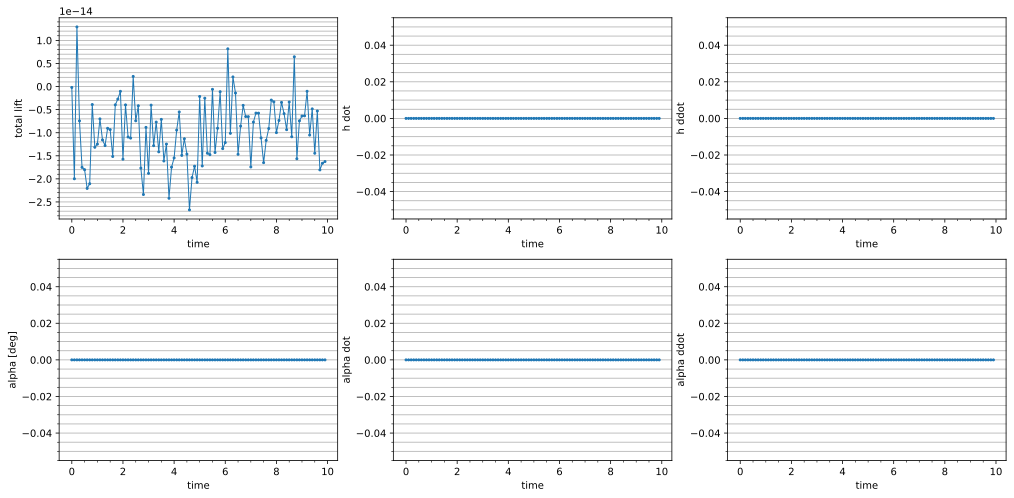

In [11]:
%config InlineBackend.figure_format = 'svg'
fig, axarr = plotfile(info)

INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.HTMLWriter'>


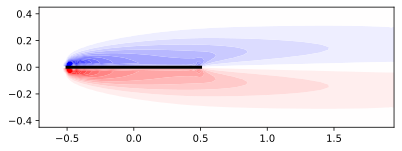

In [12]:
xg, yg = Main.seval("xg, yg = coordinates(vorticity(integrator),g)")
pivot_idx = (env.unwrapped.a, 0)
anim = animaterender_contour(info, xg, yg, render_list, pivot_idx, mylevels);
anim

## Impulse

In [13]:
env.reset(options={"h_ddot_prescribed":h_ddot_impulse});

INFO:root:No reference lift provided, using zeros instead


In [14]:
obs, info, render_list = evaluate(env)

INFO:root:No reference lift provided, using zeros instead


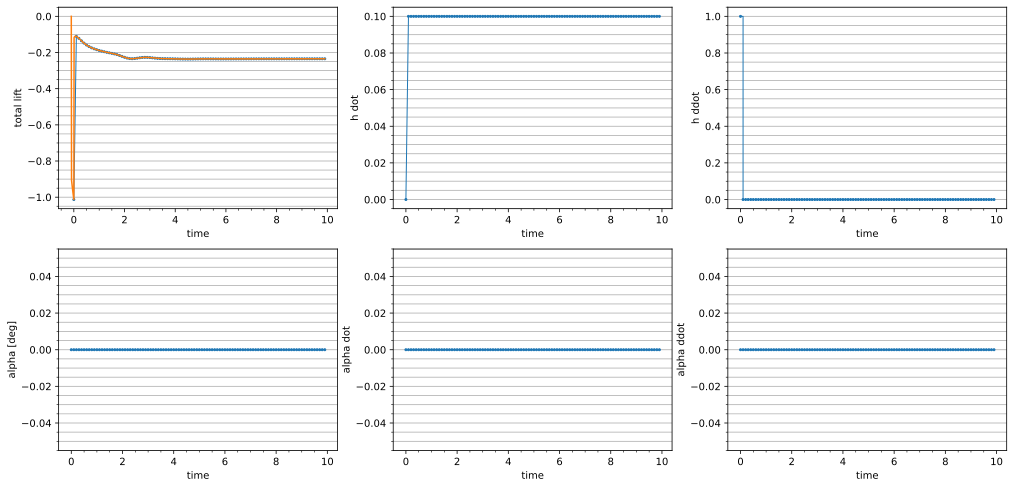

In [15]:
%config InlineBackend.figure_format = 'svg'
fig, axarr = plotfile(info)
axarr[0,0].plot(info["solver_t_hist"], info["solver_fy_hist"])

INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.HTMLWriter'>


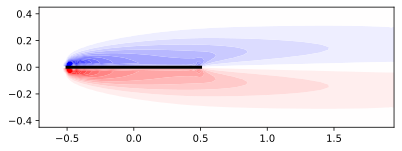

In [16]:
xg, yg = Main.seval("xg, yg = coordinates(vorticity(integrator),g)")
pivot_idx = (env.unwrapped.a, 0)
anim = animaterender_contour(info, xg, yg, render_list, pivot_idx, mylevels);
anim

## Step

In [17]:
env.reset(options={"h_ddot_prescribed":0.1*h_ddot_ones});

INFO:root:No reference lift provided, using zeros instead


In [18]:
obs, info, render_list = evaluate(env)

INFO:root:No reference lift provided, using zeros instead


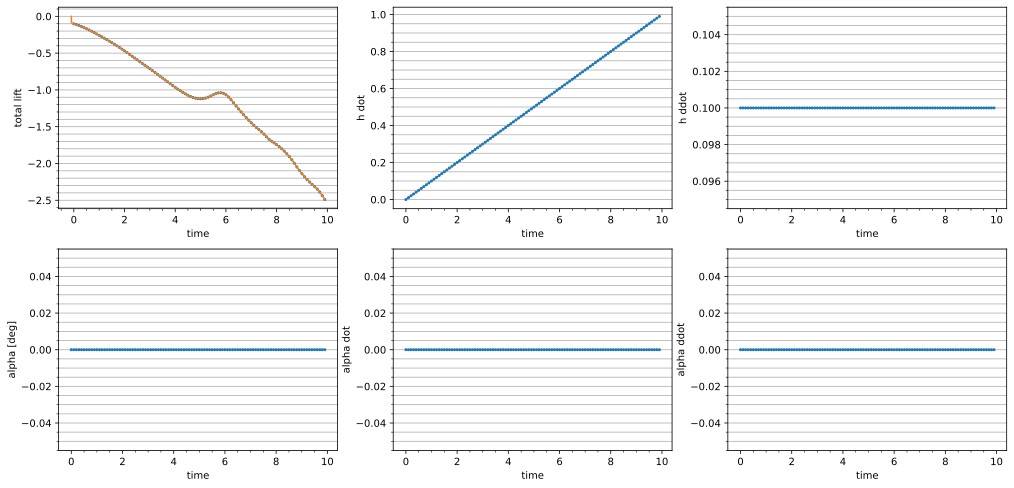

In [19]:
%config InlineBackend.figure_format = 'svg'
fig, axarr = plotfile(info)
axarr[0,0].plot(info["solver_t_hist"], info["solver_fy_hist"])

INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.HTMLWriter'>


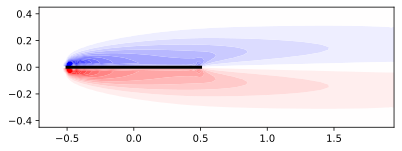

In [20]:
xg, yg = Main.seval("xg, yg = coordinates(vorticity(integrator),g)")
pivot_idx = (env.unwrapped.a, 0)
anim = animaterender_contour(info, xg, yg, render_list, pivot_idx, mylevels);
anim

## Gaussian

In [21]:
def gaussian(x, a, b, c):
    return a * math.exp(-(x - b) ** 2 / (2 * c ** 2))

def dgaussian(x, a, b, c):
    return a * -(x - b) / c ** 2 * math.exp(-(x - b) ** 2 / (2 * c ** 2))

def ddgaussian(x, a, b, c):
    return a * (x ** 2 + b ** 2 - 2 * b * x - c ** 2) / c ** 4 * math.exp(-(x - b) ** 2 / (2 * c ** 2))

In [22]:
a = -2/3
b = 3.0
c = 0.4
h_ddot_dgaussian = [0.25 * dgaussian(ti, a, b, c) for ti in t]

a = 1/6
b = 8.0
c = 0.4
alpha_ddot_dgaussian = [ddgaussian(ti, a, b, c) for ti in t]

In [23]:
env.reset(options={"h_ddot_prescribed":h_ddot_dgaussian});

INFO:root:No reference lift provided, using zeros instead


In [24]:
obs, info, render_list = evaluate(env, alpha_ddot_prescribed=alpha_ddot_dgaussian)

INFO:root:No reference lift provided, using zeros instead


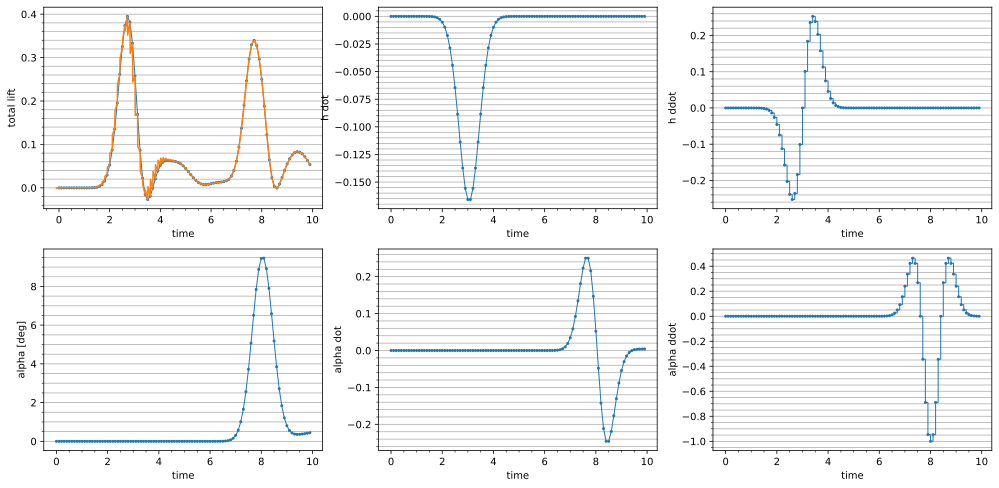

In [25]:
%config InlineBackend.figure_format = 'svg'
fig, axarr = plotfile(info)
axarr[0,0].plot(info["solver_t_hist"], info["solver_fy_hist"])

INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.HTMLWriter'>


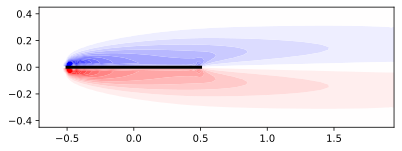

In [26]:
xg, yg = Main.seval("xg, yg = coordinates(vorticity(integrator),g)")
pivot_idx = (env.unwrapped.a, 0)
matplotlib.rcParams['image.interpolation'] = 'none'
anim = animaterender_contour(info, xg, yg, render_list, pivot_idx, mylevels, animate_every=2);
anim